# Importing Libararies

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from matplotlib.pyplot import imshow
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras import layers

# Looking into structure of file arrangements

In [2]:
DIR = '/kaggle/input/nepali-celeb-localized-face-dataset/Dataset/Dataset/'

In [6]:
files = os.listdir(DIR)
print(files)
class_count = len(files)
print(f'There are {class_count} classes.')

['Sandeep Chhetri', 'Gagan Thapa', 'Shilpa Pokharel', 'yama buddha', 'Shree Krishna Shrestha', 'Shristi Shrestha', 'Gauri Malla', 'Anmol KC', 'Paul Shah', 'Shilpa Maskey', 'Amrita Acharia', 'Priyanka Karki', 'Namrata Shrestha', 'Malina Joshi', 'Dayahang Rai', 'Saugat Malla', 'Pooja Sharma', 'Shrinkhala Khatiwada', 'Barsha Raut', 'Sabin Shrestha', 'Nischal Basnet', 'Jiwan Luitel', 'Rohit John Chettri', 'Shiva Hari Poudel', 'Kushal Thapa', 'Udit Narayan', 'Ishan Pandey', 'Paras Khadka', 'Rajesh Hamal', 'Ramesh Upreti', 'Samragyee RL Shah', 'Nita Dhungana', 'Swastima Khadka', 'Niraj Baral', 'Anuradha Koirala', 'Laxmi Prasad Devkota', 'Salon Basnet', 'Manisha Koirala', 'Reecha Sharma', 'Aryan Sigdel', 'Keki Adhikari', 'Bhuwan KC', 'Rabindra Jha', 'Anoop Bikram Shahi', 'Garima Panta', 'Karishma Manandhar', 'Arpan Thapa', 'Pradeep Khadka', 'Deepak Raj Giri']
There are 49 classes.


In [4]:
# Remove Non JPG images
for cls in files:
    cls_path = os.path.join(DIR, cls)
    imgs =  os.listdir(cls_path)
    img = Image.open(os.path.join(cls_path,imgs[0]))
    print(f'Class {cls} contains {len(imgs)} images images of shape {img.size}.')

Class Sandeep Chhetri contains 31 images images of shape (275, 275).
Class Gagan Thapa contains 32 images images of shape (357, 357).
Class Shilpa Pokharel contains 40 images images of shape (151, 151).
Class yama buddha contains 25 images images of shape (258, 258).
Class Shree Krishna Shrestha contains 26 images images of shape (174, 174).
Class Shristi Shrestha contains 43 images images of shape (378, 378).
Class Gauri Malla contains 47 images images of shape (145, 145).
Class Anmol KC contains 33 images images of shape (229, 229).
Class Paul Shah contains 34 images images of shape (237, 237).
Class Shilpa Maskey contains 35 images images of shape (109, 109).
Class Amrita Acharia contains 42 images images of shape (230, 230).
Class Priyanka Karki contains 41 images images of shape (221, 221).
Class Namrata Shrestha contains 31 images images of shape (290, 290).
Class Malina Joshi contains 40 images images of shape (224, 224).
Class Dayahang Rai contains 45 images images of shape (26

# Creating the data generator using ImageDataGenerator for the CNN

In [8]:
def train_val_generators():
    """
    Creates the training and validation data generators
    Returns:
        train_generator, validation_generator: tuple containing the generators
    """
    # Instantiate the ImageDataGenerator class, normalize pixel values and set arguments to augment the images 
    datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='nearest',
                                 validation_split=0.2)                               
    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = datagen.flow_from_directory(directory=DIR,
                                                        batch_size=100, 
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        subset='training',                         
                                                        target_size=(75,75))

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = datagen.flow_from_directory(directory=DIR,
                                                                  batch_size=36, 
                                                                  class_mode='categorical',
                                                                  shuffle = False,
                                                                  subset='validation', 
                                                                  target_size=(75, 75))
    return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators()

Found 1326 images belonging to 49 classes.
Found 310 images belonging to 49 classes.


# Define and compile the transfer learning model

In [10]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
                                input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [11]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [11]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 768)


In [12]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (class_count, activation='softmax')(x)           

# Append the dense network to the base model
model_transfer = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]']

In [19]:
model_transfer.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Creating a Callback class

In [14]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the correct function signature for on_epoch_end
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.99): 
            print(logs.get('val_accuracy'))
            print("\nReached 99% validation accuracy so cancelling training!")
callbacks = myCallback()

In [15]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.25,   
    patience=2, 
    min_lr=0.00001,
    verbose=2
)

In [17]:
checkpoint_path = "/kaggle/working/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model

In [20]:
history1 = model_transfer.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator, 
                    callbacks=[callbacks, reduce_lr, cp_callback]
                   )

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 4.0897 - accuracy: 0.0452
Epoch 1: saving model to /kaggle/working/cp.ckpt
14/14 [==============================] - 28s 2s/step - loss: 4.0897 - accuracy: 0.0452 - val_loss: 3.6677 - val_accuracy: 0.0613 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 3.4962 - accuracy: 0.1169
Epoch 2: saving model to /kaggle/working/cp.ckpt
14/14 [==============================] - 13s 987ms/step - loss: 3.4962 - accuracy: 0.1169 - val_loss: 3.4435 - val_accuracy: 0.1323 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 3.2439 - accuracy: 0.1546
Epoch 3: saving model to /kaggle/working/cp.ckpt
14/14 [==============================] - 13s 910ms/step - loss: 3.2439 - accuracy: 0.1546 - val_loss: 3.3251 - val_accuracy: 0.1355 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 3.0999 - accuracy: 0.1983
Epoch 4: saving model to /kaggle/working/cp.c

In [21]:
print("Accuracy of the transfer_learning model is - " , model_transfer.evaluate(validation_generator)[1]*100 , "%")

9/9 [==============================] - 2s 259ms/step - loss: 2.6353 - accuracy: 0.3484
Accuracy of the transfer_learning model is -  34.838709235191345 %


#  Evaluating Accuracy and Loss for the Model

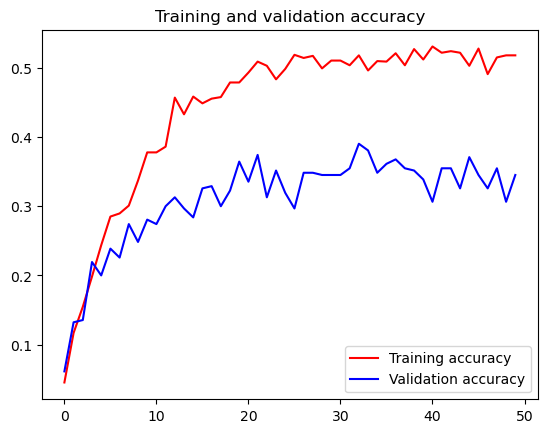

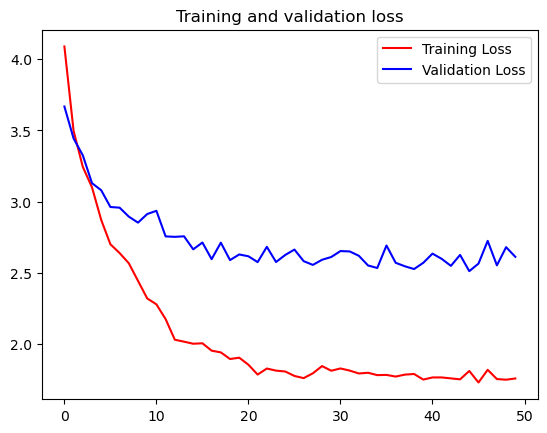

In [22]:
# Plot the chart for accuracy and loss on both training and validation
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
predictions = model_transfer.predict(validation_generator)
predictions=np.argmax(predictions,axis=-1)
print(predictions[:10])
print(validation_generator.labels[:10])

9/9 [==============================] - 4s 270ms/step
[ 0  0  0 45 45  0  0  0  1 17]
[0 0 0 0 0 0 0 0 1 1]


In [24]:
dict_cls = validation_generator.class_indices


In [25]:
list(dict_cls.keys())

['Amrita Acharia',
 'Anmol KC',
 'Anoop Bikram Shahi',
 'Anuradha Koirala',
 'Arpan Thapa',
 'Aryan Sigdel',
 'Barsha Raut',
 'Bhuwan KC',
 'Dayahang Rai',
 'Deepak Raj Giri',
 'Gagan Thapa',
 'Garima Panta',
 'Gauri Malla',
 'Ishan Pandey',
 'Jiwan Luitel',
 'Karishma Manandhar',
 'Keki Adhikari',
 'Kushal Thapa',
 'Laxmi Prasad Devkota',
 'Malina Joshi',
 'Manisha Koirala',
 'Namrata Shrestha',
 'Niraj Baral',
 'Nischal Basnet',
 'Nita Dhungana',
 'Paras Khadka',
 'Paul Shah',
 'Pooja Sharma',
 'Pradeep Khadka',
 'Priyanka Karki',
 'Rabindra Jha',
 'Rajesh Hamal',
 'Ramesh Upreti',
 'Reecha Sharma',
 'Rohit John Chettri',
 'Sabin Shrestha',
 'Salon Basnet',
 'Samragyee RL Shah',
 'Sandeep Chhetri',
 'Saugat Malla',
 'Shilpa Maskey',
 'Shilpa Pokharel',
 'Shiva Hari Poudel',
 'Shree Krishna Shrestha',
 'Shrinkhala Khatiwada',
 'Shristi Shrestha',
 'Swastima Khadka',
 'Udit Narayan',
 'yama buddha']

#  Evaluating  Precision, Recall, F1-Score and Support for the Model

In [26]:
print(classification_report(validation_generator.labels, predictions, target_names = list(dict_cls.keys())))

                        precision    recall  f1-score   support

        Amrita Acharia       0.50      0.75      0.60         8
              Anmol KC       0.43      0.50      0.46         6
    Anoop Bikram Shahi       0.20      0.17      0.18         6
      Anuradha Koirala       0.22      0.33      0.27         6
           Arpan Thapa       0.67      0.40      0.50         5
          Aryan Sigdel       0.33      0.40      0.36         5
           Barsha Raut       0.10      0.14      0.12         7
             Bhuwan KC       0.11      0.14      0.12         7
          Dayahang Rai       0.60      0.33      0.43         9
       Deepak Raj Giri       0.30      0.50      0.37         6
           Gagan Thapa       0.56      0.83      0.67         6
          Garima Panta       0.33      0.29      0.31         7
           Gauri Malla       0.50      0.44      0.47         9
          Ishan Pandey       0.33      0.17      0.22         6
          Jiwan Luitel       0.33      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plotting the Confusion Matrix for the Classification

<AxesSubplot:>

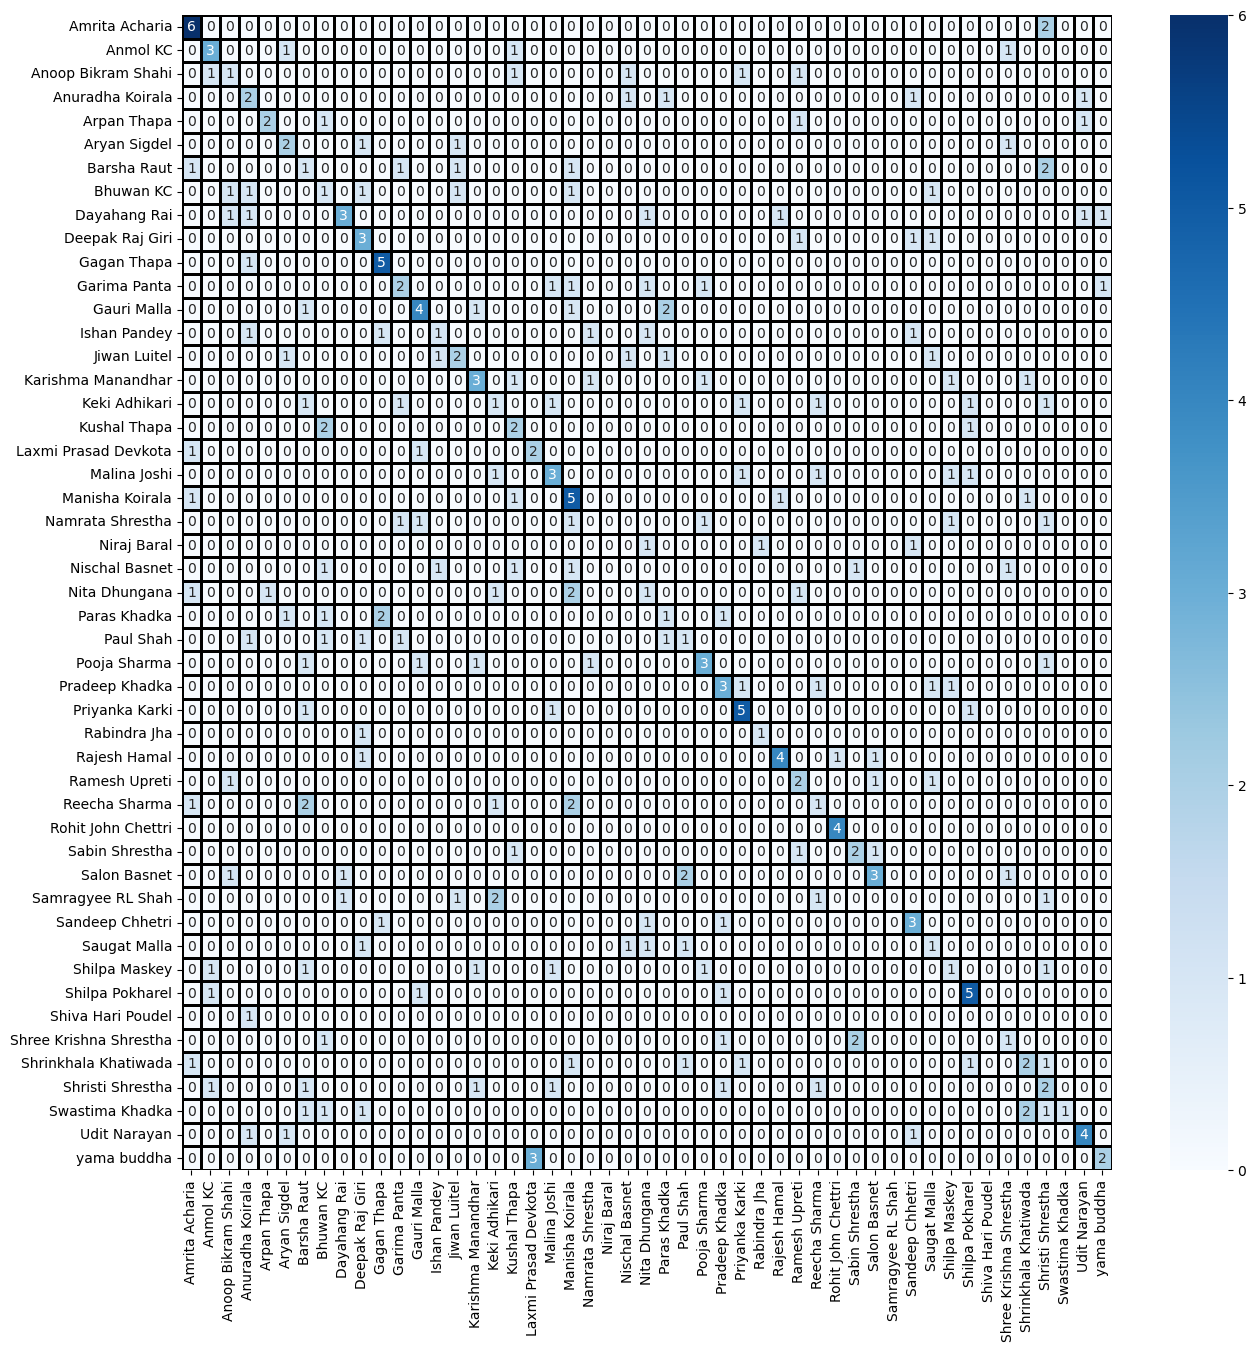

In [27]:
cm = confusion_matrix(validation_generator.labels,predictions)
cm = pd.DataFrame(cm , index = list(dict_cls.keys()) , columns = list(dict_cls.keys()))
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

# Sample Model Prediction

In [28]:
def class_name(id):
    key_list = list(dict_cls.keys())
    val_list = list(dict_cls.values())
    position = val_list.index(id)
    return key_list[position]

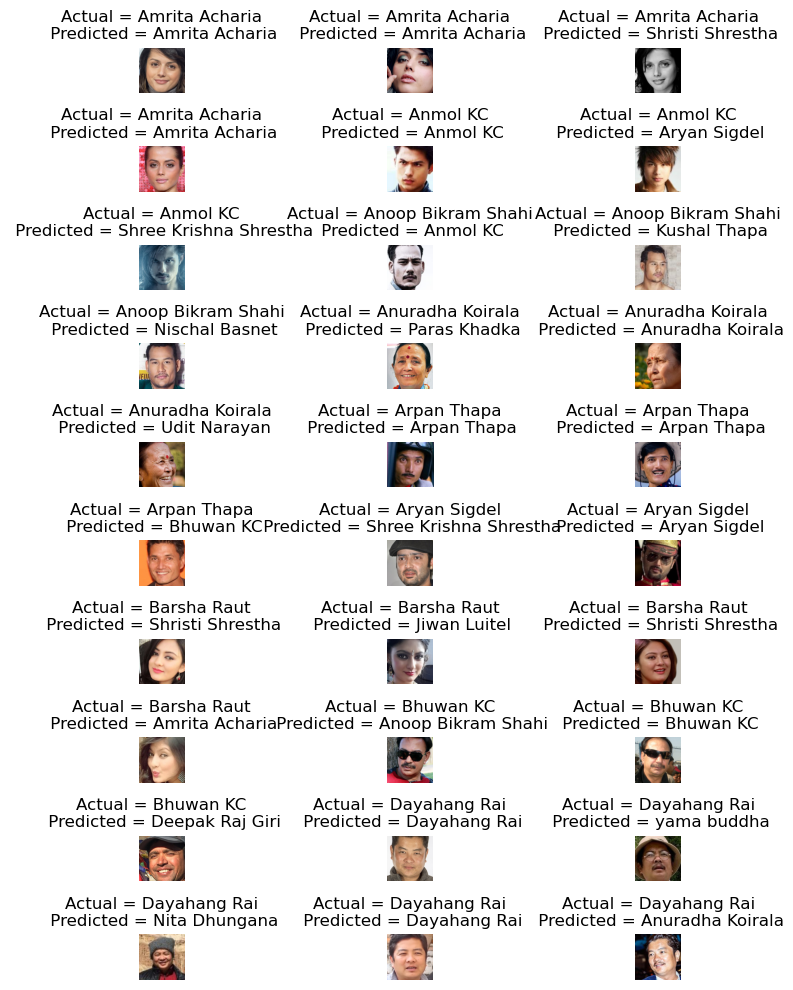

In [32]:
f, ax = plt.subplots(10,3) 
f.set_size_inches(10, 10)
k = 0
for i in range(10):
    for j in range(3):
        true_cls = validation_generator.labels[k]
        true_cls = class_name(true_cls)
        pred_cls = predictions[k]
        pred_cls = class_name(pred_cls)
        ax[i,j].set_title(f'Actual = {true_cls}\n Predicted = {pred_cls}')
        img=plt.imread(DIR+validation_generator.filenames[k])
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        k += 2
    
    plt.tight_layout() 